# Top 5 Quotes dummy model

In [1]:
import pandas as pd
import itertools
import re
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import string
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file = "../raw_data/quotes - reduced.csv"
quotes = pd.read_csv(file, decimal=",")
quotes.head(3)

,quote,author,category
0,"I'm selfish, impatient and a little insecure. ...",Marilyn Monroe,"attributed-no-source, best, life, love, mistak..."
1,You've gotta dance like there's nobody watchin...,William W. Purkey,"dance, heaven, hurt, inspirational, life, love..."
2,You know you're in love when you can't fall as...,Dr. Seuss,"attributed-no-source, dreams, love, reality, s..."


In [3]:
tags_list = quotes.category.to_list()
number_of_tags = []
for i in tags_list:
    number_of_tags.append(len(str(i).split(',')))

In [4]:
quotes['quotes_length'] = quotes['quote'].copy()
for index, row in quotes.iterrows():
    quotes.loc[index, "quotes_length"] = len(str(row['quotes_length']).split(' '))

## Cleaning data: tags are all lowercase, '-' were replaced with ',', duplicates were removed

In [5]:
for index, row in quotes.iterrows():
    quotes.loc[index, "category"] = str(row['category']).lower().replace('-',', ')

In [6]:
quotes['list_tags'] = quotes['category'].copy()
for index,row in quotes.iterrows():
    quotes.loc[index, 'count_tags'] = len(str(row['list_tags']).split(','))
quotes.count_tags.describe()

count    154318.000000
mean          9.758272
std          15.418337
min           1.000000
25%           3.000000
50%           5.000000
75%          11.000000
max         568.000000
Name: count_tags, dtype: float64

In [7]:
for index,row in quotes.iterrows():
    quotes.at[index, 'list_tags'] = str(row['list_tags']).split(',')

In [8]:
for index,row in quotes.iterrows():
    quotes.at[index, 'list_tags'] = str(set(row['list_tags']))

In [9]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
quotes['list_tags'] = quotes['list_tags'].apply(remove_punctuations)

In [10]:
vectorizer = TfidfVectorizer()
tags_vectorized = vectorizer.fit_transform(quotes['list_tags'])
dummy_tags = LatentDirichletAllocation(n_components=5)
lda_vectors = dummy_tags.fit_transform(tags_vectorized)

In [11]:
def print_topics(model, vectorizer):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-10 - 1:-1]])
        

print_topics(dummy_tags, vectorizer.fit(quotes['list_tags']))

Topic 0:
[('inspirational', 4495.69088686116), ('life', 3456.2995365162265), ('quotes', 2772.7161990089303), ('love', 2662.4566438363886), ('wisdom', 2389.775202591504), ('truth', 1933.535179062117), ('philosophy', 1891.2313482005045), ('happiness', 1887.7640765934411), ('hope', 1847.778903051943), ('faith', 1640.4246095798194)]
Topic 1:
[('music', 1127.8149313675594), ('debasish', 1104.151977974746), ('marriage', 1101.4112228298363), ('quotes', 1022.8006599108156), ('love', 863.3608311170866), ('mridha', 805.257909110759), ('women', 769.4757700276647), ('inspirational', 683.4118067196921), ('war', 672.7254647087663), ('quote', 624.0702274291147)]
Topic 2:
[('writing', 2081.6160400097065), ('books', 1645.7791801647754), ('reading', 1361.990184150408), ('art', 1271.2786307405652), ('poetry', 960.5554135924584), ('history', 916.3455280384553), ('fiction', 724.0800317606304), ('education', 645.2553955721108), ('children', 586.5805911960216), ('literature', 488.23193944689103)]
Topic 3:
[(

In [12]:
lda_vectors[1]

array([0.06181121, 0.47106712, 0.0586053 , 0.0586774 , 0.34983896])

In [15]:
quotes.head()

,quote,author,category,quotes_length,list_tags,count_tags
0,"I'm selfish, impatient and a little insecure. ...",Marilyn Monroe,"attributed, no, source, best, life, love, mist...",41,of best out truth worst source mistakes...,12.0
1,You've gotta dance like there's nobody watchin...,William W. Purkey,"dance, heaven, hurt, inspirational, life, love...",22,heaven sing inspirational love hurt dance...,7.0
2,You know you're in love when you can't fall as...,Dr. Seuss,"attributed, no, source, dreams, love, reality,...",18,source dreams sleep reality no attributed...,7.0
3,A friend is someone who knows all about you an...,Elbert Hubbard,"friend, friendship, knowledge, love",13,knowledge friend friendship love,4.0
4,Darkness cannot drive out darkness: only light...,"Martin Luther King Jr., A Testament of Hope: T...","darkness, drive, out, hate, inspirational, lig...",20,light darkness out hate drive inspiration...,8.0


In [16]:
quotes.iloc[-1] = ['A large crowd is assembled on an outdoor street scene , with toy balloons visible and a woman walking a pink bicyc', 'image','image','5','A large crowd is assembled on an outdoor street scene , with toy balloons visible and a woman walking a pink bicyc','1']

In [17]:
picture_vectorized = vectorizer.transform(quotes.iloc[-1])
lda_vectors_self = dummy_tags.transform(picture_vectorized)
for index,row in quotes.iterrows():
    quotes['topic'] = quotes.quote.copy()

In [18]:
for index,row in quotes.iterrows():
    quotes.at[index, 'topic'] = int(np.where(lda_vectors[index] == max(lda_vectors[index]))[0])

In [19]:
quotes.tail()

,quote,author,category,quotes_length,list_tags,count_tags,topic
154313,The harassed look is that of a desperately tir...,"Christopher Isherwood, A Single Man","dying, living",96,dying living,2.0,4
154314,…In this way that he sought to control the ver...,"Jesse Ball, The Curfew","life, living, mindfulness",39,mindfulness life living,3.0,4
154315,"No matter how we choose to live, we both die a...","Adam Silvera, They Both Die at the End","death, living",13,living death,2.0,4
154316,The goal that you hope you will one day arrive...,"Marcus Aurelius, The Essential Marcus Aurelius",living,239,living,1.0,0
154317,A large crowd is assembled on an outdoor stree...,image,image,5,A large crowd is assembled on an outdoor stree...,1,4


(array([44286.,     0., 26831.,     0.,     0., 19963.,     0., 32735.,
            0., 30503.]),
 array([0.0, 0.4, 0.8, 1.2000000000000002, 1.6, 2.0, 2.4000000000000004,
        2.8000000000000003, 3.2, 3.6, 4.0], dtype=object),
 <BarContainer object of 10 artists>)

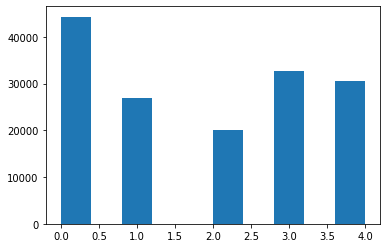

In [20]:
plt.hist(quotes.topic)

__Adding the image caption as the last line to our dataset to be able to see the closest neighbourhs__

In [21]:
image_topic = int(quotes.iloc[-1, [-1]])
image_topic

4

In [22]:
quotes = quotes.dropna()
only_topic = quotes[quotes.topic == image_topic]
only_topic.head()

,quote,author,category,quotes_length,list_tags,count_tags,topic
4,Darkness cannot drive out darkness: only light...,"Martin Luther King Jr., A Testament of Hope: T...","darkness, drive, out, hate, inspirational, lig...",20,light darkness out hate drive inspiration...,8.0,4
23,"Love is like the wind, you can't see it but yo...","Nicholas Sparks, A Walk to Remember","love, simile",14,love simile,2.0,4
28,Love never dies a natural death. It dies becau...,Anaïs Nin,"death, love",39,love death,2.0,4
34,"Dumbledore watched her fly away, and as her si...","J.K. Rowling, Harry Potter and the Deathly Hal...","dumbledore, life, love, snape",28,dumbledore snape love life,4.0,4
36,To die will be an awfully big adventure.,"J.M. Barrie, Peter Pan","adventure, love",8,adventure love,2.0,4


In [23]:
tfidf_weight = vectorizer.fit_transform(only_topic['list_tags'].values.astype('U'))
nn_euc = NearestNeighbors(metric = 'euclidean')
nn_euc.fit(tfidf_weight)
image_index = -1
euc, indices = nn_euc.kneighbors(tfidf_weight[image_index], n_neighbors = 100)
neighbors_euc = pd.DataFrame({'euc': euc.flatten(), 'id': indices.flatten()})
result_top5 = (only_topic.merge(neighbors_euc, right_on = 'id', left_index = True).
                sort_values('euc')[['quote', 'author']]).head()

result_top5

,quote,author
7,I died. I died and someone made a clerical err...,"Jim Butcher, Summer Knight"
9,"Our revels now are ended. These our actors, As...","William Shakespeare, The Tempest"
12,"Which way did they go, Peeves?"" Filch was sayi...","J.K. Rowling, Harry Potter and the Sorcerer's ..."
18,"I hold it true, whate'er befall;I feel it when...","Alfred Tennyson, In Memoriam"
24,Falling in love is not a rational process. It ...,"Suzanne Selfors, Coffeehouse Angel"


In [24]:
most_suiting = quotes[quotes.topic != image_topic]
own_tags = input("Please give me 5 words that are descriptive of your picture:")
most_suiting.iloc[-1] = [own_tags,'image','image','5',own_tags,'1',image_topic]
most_suiting.tail()

Please give me 5 words that are descriptive of your picture:bycicle


/tmp/ipykernel_19315/101407589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_suiting.iloc[-1] = [own_tags,'image','image','5',own_tags,'1',image_topic]


,quote,author,category,quotes_length,list_tags,count_tags,topic
154308,Haldir had gone on and was now climbing to the...,"J.R.R. Tolkien, The Lord of the Rings","living, tree",80,tree living,2.0,1
154309,"Trust that whatever you are dealing with, what...","Barbara Marciniak, Family of Light: Pleiadian ...","crisis, living, love",41,crisis living love,3.0,3
154310,"The venerable teachers, philosophers & spiritu...","Allan Lokos, Pocket Peace: Effective Practices...","buddhism, healing, health, inspirational, livi...",27,buddhism healing health living inspiration...,7.0,0
154312,Sasha's green eyes were right up against yours...,"Jennifer Egan, A Visit from the Goon Squad","coping, living, survival",77,survival living coping,3.0,0
154316,bycicle,image,image,5,bycicle,1,4


In [25]:
tfidf_weight = vectorizer.fit_transform(most_suiting['list_tags'].values.astype('U'))
nn_euc = NearestNeighbors(metric = 'euclidean')
nn_euc.fit(tfidf_weight)
image_index = -1
euc, indices = nn_euc.kneighbors(tfidf_weight[image_index], n_neighbors = 100)
neighbors_euc = pd.DataFrame({'euc': euc.flatten(), 'id': indices.flatten()})
result_most_s = (only_topic.merge(neighbors_euc, right_on = 'id', left_index = True).
                sort_values('euc')[['quote', 'author']]).head(1)

result_most_s.quote

42    I must die. Must I then die lamenting? I must ...
Name: quote, dtype: object